In [1]:
import numpy as np

# Load the arrays
results_matrix = np.load('results_matrix.npy')
success_rate_matrix = np.load('success_rate_matrix.npy')
total_results_matrix = np.load('total_results_matrix.npy')

# Inspect their shapes and contents
print("Results Matrix Shape:", results_matrix.shape)
print("Results Matrix:\n", results_matrix)

print("Success Rate Matrix Shape:", success_rate_matrix.shape)
print("Success Rate Matrix:\n", success_rate_matrix)

print("Total Results Matrix Shape:", total_results_matrix.shape)
print("Total Results Matrix:\n", total_results_matrix)

Results Matrix Shape: (1, 5, 4, 6)
Results Matrix:
 [[[[ 7.89048877  9.04253212  8.41142368 10.40651226  9.3129673
     9.45787525]
   [ 9.22367246  9.98740213  9.46565819 10.69382    10.46820641
    10.33647919]
   [ 8.0791856   8.13537303  7.64078426 14.04210186  7.9501009
     9.1117506 ]
   [ 7.08861716  7.49293255  6.7791152  13.19136238  6.98149109
     8.21280003]]

  [[ 7.87068374  8.99631131  8.06746864  9.38176918  8.8401165
     8.95460701]
   [ 8.64632514  9.01429963  8.59613514 23.51956558  8.98876667
     9.96865559]
   [ 7.96420824  7.89174213  7.7271452  19.18579102  8.12060738
     9.50305748]
   [ 7.18209163  6.93172051  6.83101177 11.44020271  7.27197409
     8.62672424]]

  [[10.2993418  11.59032964 10.4595623  12.06692314 10.68587208
    11.25533962]
   [ 9.15398535  8.89498036  9.07241535 21.03604889  9.36730003
     9.96786976]
   [ 9.75908379  9.1279325   9.23566437 26.47247696 10.04658699
    10.63187122]
   [ 9.22262851  8.62076051  8.50871468 18.36701393  9.1

IndexError: list index out of range

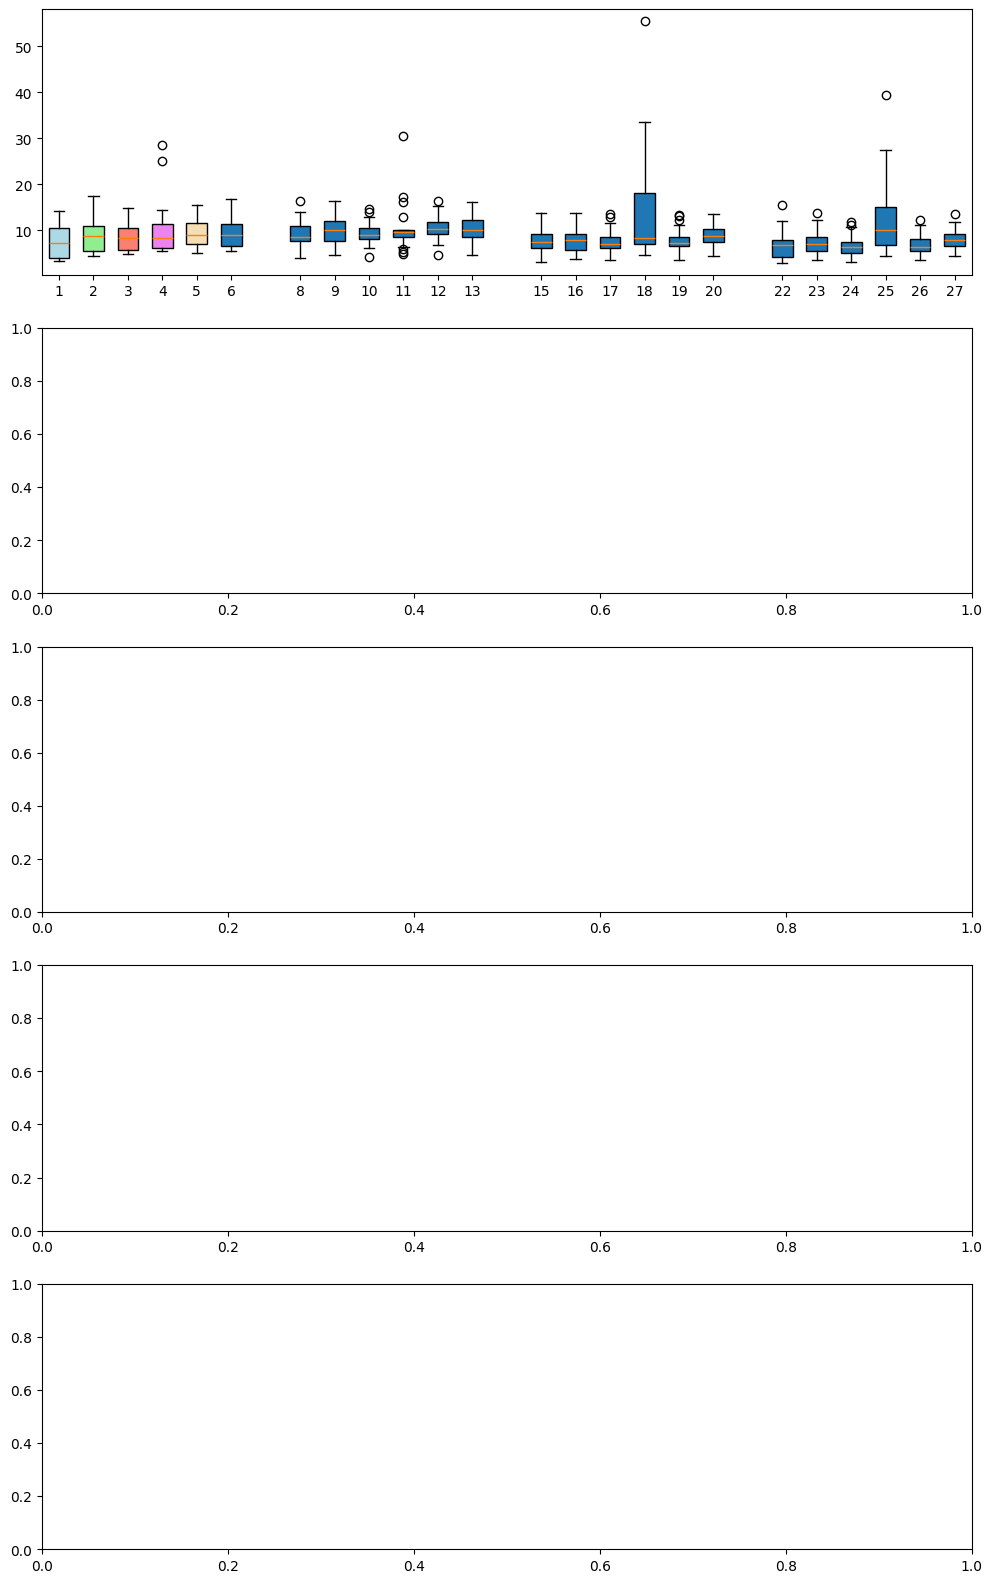

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_boxplots_by_hyper1(loss_data: np.ndarray,
                            hyperparam1_labels=["30", "60", "90", "120", "150"],
                            hyperparam2_labels=["1% supervision", "5% supervision", "10% supervision", "15% supervision"],
                            model_labels=["Bridged Clustering", "KNN", "Mean Teacher", "GCN", "AGDN", "Bridged AGDN"],
                            log_scale=False):
    """
    Create a figure with 5 subplots (one for each value of hyperparameter 1).
    In each subplot the loss distributions are shown as grouped boxplots for the
    4 hyperparameter 2 configurations. Within each group, the 5 boxplots correspond
    to the 5 models.

    Parameters:
      - loss_data: NumPy array of shape (1, 5, 4, 5, 20) or (5, 4, 5, 20).
                   Each entry represents the loss for a particular trial.
      - hyperparam1_labels: List of labels for hyperparameter 1 (default: "H1-0", "H1-1", ...).
      - hyperparam2_labels: List of labels for hyperparameter 2 (default: "H2-0", "H2-1", ...).
      - model_labels: List of labels for models (default: "Model 1", "Model 2", ...).
      - log_scale: Boolean, if True the y-axis will be set to a logarithmic scale.
    """
    # Remove the wrapper dimension, if present.
    if loss_data.shape[0] == 1:
        loss_data = loss_data[0]  # Now shape should be (5, 4, 5, 20)
        
    # Unpack shape
    num_h1, num_h2, num_models, num_trials = loss_data.shape  # 5,4,5,20

    # Set default labels if needed.
    if hyperparam1_labels is None:
        hyperparam1_labels = [f'H1-{i}' for i in range(num_h1)]
    if hyperparam2_labels is None:
        hyperparam2_labels = [f'H2-{i}' for i in range(num_h2)]
    if model_labels is None:
        model_labels = [f'Model {i+1}' for i in range(num_models)]
    
    # Define a color for each model (consistent across all subplots)
    colors = ['lightblue', 'lightgreen', 'salmon', 'violet', 'wheat', 'lightgrey']

    # Create the figure with one subplot per hyperparameter 1 value.
    fig, axes = plt.subplots(nrows=num_h1, ncols=1, figsize=(12, 4 * num_h1), sharex=False)
    
    # In case there is only one subplot (num_h1==1), force axes to be iterable.
    if num_h1 == 1:
        axes = [axes]

    # Loop over hyperparameter 1 values, each gets its own subplot.
    for i in range(num_h1):
        ax = axes[i]
        data_all = []    # to collect the loss arrays for each group/model
        positions = []   # the x positions at which to put each boxplot
        group_centers = []  # to mark center of each hyperparam2 group for labeling
        
        gap = 1  # gap between groups (in x-axis units)
        # Loop over the 4 hyperparameter 2 values for this hyperparameter 1 configuration.
        for j in range(num_h2):
            base = j * (num_models + gap)  # starting position for this group
            # positions for each of the 5 models within this group.
            pos = list(range(base + 1, base + 1 + num_models))
            # For each model in this hyper 2 group, extract the 20 loss values.
            for m in range(num_models):
                data_all.append(loss_data[i, j, m, :])
                positions.append(pos[m])
            group_centers.append(np.mean(pos))
        
        # Create the boxplots for this subplot.
        bp = ax.boxplot(data_all, positions=positions, widths=0.6,
                        patch_artist=True, showfliers=True)
        
        # Color each box based on its model. Since for each group the boxes
        # appear in order (model 0 through model 4), we use modulo arithmetic.
        for idx, box in enumerate(bp['boxes']):
            model_idx = idx % num_models  # cycles from 0 to 4
            box.set(facecolor=colors[model_idx])
        
        # Set the x-axis ticks at the centers of each hyperparam2 group.
        ax.set_xticks(group_centers)
        ax.set_xticklabels(hyperparam2_labels, fontsize=10)
        ax.set_ylabel("Loss", fontsize=12)
        ax.set_title(f"Loss Distributions for {hyperparam1_labels[i]}", fontsize=14)
        if log_scale:
            ax.set_yscale("log")
    
    # Create a custom legend for the models (appears outside the subplots)
    from matplotlib.patches import Patch
    legend_handles = [Patch(facecolor=colors[i], edgecolor='k', label=model_labels[i])
                      for i in range(num_models)]
    # Place legend to the right of the plots.
    plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space on the right for the legend
    plt.show()

plot_boxplots_by_hyper1(total_results_matrix, log_scale=True)

In [2]:
def calculate_success_rate(results: np.ndarray) -> np.ndarray:
    """
    Calculate the success rate for each model under different hyperparameter settings.
    
    Parameters:
        results (np.ndarray): A 5-dimensional numpy array of shape (1, 5, 4, 5, 20)
                              containing loss values. The dimensions correspond to:
                              - 1: Wrapper dimension (to be removed)
                              - 5: First hyperparameter setting with 5 choices
                              - 4: Second hyperparameter setting with 4 choices
                              - 5: 5 different models
                              - 20: 20 experimental trials per setting
                              
    Returns:
        np.ndarray: A 3-dimensional array of shape (5, 4, 5) where each entry represents
                    the fraction (success rate) of trials in which the corresponding model was
                    the unique best (i.e. had the smallest loss) for that hyperparameter setting.
    
    Notes:
        - A model is counted as a success in a given trial only if its loss is strictly lower
          than the losses of every other model (i.e. it is a unique minimum for that trial).
        - If more than one model ties for the minimum loss in a trial, then no model is considered
          successful in that trial.
    """
    # Remove the wrapper dimension if it is of size 1:
    if results.shape[0] == 1:
        results = results[0]  # Now results shape becomes (5, 4, 5, 20)
    
    # Compute the minimum loss across models for each hyperparameter setting and trial.
    # This is done along the models axis (axis=2).
    min_vals = np.min(results, axis=2)  # Shape: (5, 4, 20)
    
    # Expand dims for correct broadcasting: add a new axis in the models dimension.
    min_vals_expanded = min_vals[:, :, None, :]  # Shape becomes (5, 4, 1, 20)
    
    # Create a mask for models that achieve the minimum loss by comparing each model's loss.
    is_min = (results == min_vals_expanded)  # Shape: (5, 4, 5, 20)
    
    # Count the number of models that achieved the minimum loss for each hyperparameter setting and trial.
    min_counts = np.sum(is_min, axis=2)  # Shape: (5, 4, 20)
    
    # Determine trials with a unique minimum (only one model gets the minimum)
    unique_trial = (min_counts == 1)  # Shape: (5, 4, 20)
    
    # Create a success mask that is True for entries where the model is the unique winner.
    # We use broadcasting to compare across the model axis.
    success_mask = is_min & unique_trial[:, :, None, :]  # Shape: (5, 4, 5, 20)
    
    # Count the number of successes over the trials axis.
    success_counts = np.sum(success_mask, axis=-1)  # Shape: (5, 4, 5)
    
    # Calculate success rates by dividing the success count by the number of trials (20).
    success_rates = success_counts / results.shape[-1]  # Element-wise division.
    
    return success_rates

success = calculate_success_rate(total_results_matrix)

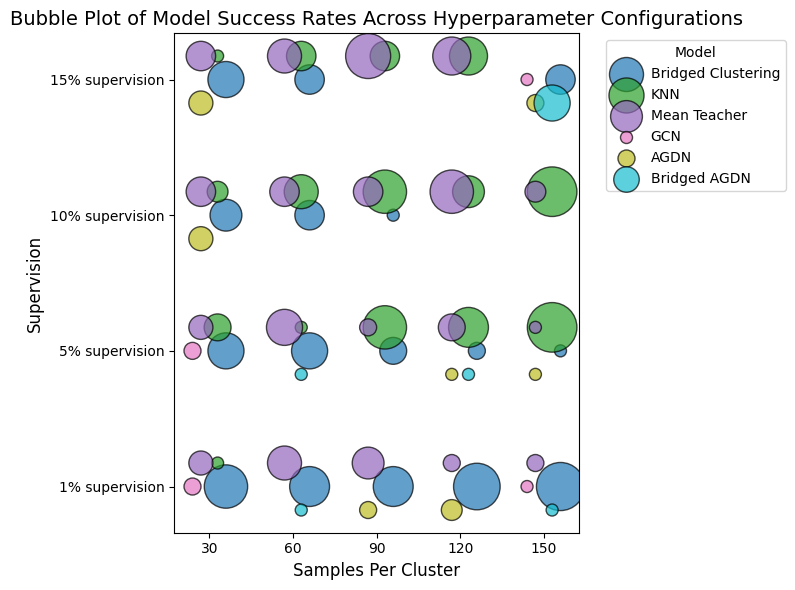

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_success_rates_bubble(success_rate_data: np.ndarray,
                              hyperparam1_labels=["30", "60", "90", "120", "150"],
                              hyperparam2_labels=["1% supervision", "5% supervision", "10% supervision", "15% supervision"],
                              model_labels=["Bridged Clustering", "KNN", "Mean Teacher", "GCN", "AGDN", "Bridged AGDN"],
                              bubble_scale=1500,
                              offset_radius=0.2):
    """
    Plot success rates in a bubble plot that preserves both hyperparameter dimensions.
    
    Each point in the grid corresponds to one hyperparameter configuration with:
      - x-axis: Hyperparameter 1 (5 choices)
      - y-axis: Hyperparameter 2 (4 choices)
    
    Within each cell, five bubbles (one per model) are plotted with a small radial offset
    to avoid overlap. The bubble size is proportional to the success rate (a value in [0,1])
    for that model at that configuration. Different colors indicate different models.
    
    Parameters:
      - success_rate_data: A numpy array of shape (5, 4, 5) where:
                           * 5: choices for hyperparameter 1,
                           * 4: choices for hyperparameter 2,
                           * 5: models.
      - hyperparam1_labels: List of labels for hyperparameter 1 (default: ['H1-0', 'H1-1', ...])
      - hyperparam2_labels: List of labels for hyperparameter 2 (default: ['H2-0', 'H2-1', ...])
      - model_labels: List of labels for the models (default: ['Model 1', 'Model 2', ...])
      - bubble_scale: A scaling factor to adjust the bubble sizes (default: 1500)
      - offset_radius: The radius (in axis units) for offsetting bubbles within each cell (default: 0.2)
    """
    # Dimensions: hyperparam1 (h1) x hyperparam2 (h2) x models (n_models)
    h1, h2, n_models = success_rate_data.shape
    
    # Set default labels if not provided.
    if hyperparam1_labels is None:
        hyperparam1_labels = [f'H1-{i}' for i in range(h1)]
    if hyperparam2_labels is None:
        hyperparam2_labels = [f'H2-{j}' for j in range(h2)]
    if model_labels is None:
        model_labels = [f'Model {m+1}' for m in range(n_models)]
    
    # Create a single figure/axes.
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use a colormap (here using the tab10 palette).
    colors = plt.cm.tab10(np.linspace(0, 1, n_models))
    
    # Loop over each model, and for each hyperparameter configuration,
    # compute an offset position within the cell.
    for m in range(n_models):
        xs, ys, sizes = [], [], []
        for i in range(h1):
            for j in range(h2):
                # Compute a small offset using polar coordinates. The angle is determined
                # by the model index so that the five models spread out in a roughly circular pattern.
                angle = 2 * np.pi * m / n_models
                x_offset = offset_radius * np.cos(angle)
                y_offset = offset_radius * np.sin(angle)
                
                # The base coordinate is the (i, j) cell. Add the offset.
                xs.append(i + x_offset)
                ys.append(j + y_offset)
                
                # Bubble size: scale the success rate (in [0, 1]) using bubble_scale.
                sizes.append(success_rate_data[i, j, m] * bubble_scale)
        
        # Plot the bubbles for this model.
        ax.scatter(xs, ys, s=sizes, color=colors[m],
                   alpha=0.7, label=model_labels[m], edgecolor='k')
    
    # Set the ticks to be at integer positions corresponding to the hyperparameter indices.
    ax.set_xticks(np.arange(h1))
    ax.set_xticklabels(hyperparam1_labels, fontsize=10)
    ax.set_yticks(np.arange(h2))
    ax.set_yticklabels(hyperparam2_labels, fontsize=10)
    
    ax.set_xlabel("Samples Per Cluster", fontsize=12)
    ax.set_ylabel("Supervision", fontsize=12)
    ax.set_title("Bubble Plot of Model Success Rates Across Hyperparameter Configurations", fontsize=14)
    
    # Add a legend. Placing it outside the main axes avoids overcrowding.
    ax.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.tight_layout()
    plt.show()

plot_success_rates_bubble(success, bubble_scale=1500, offset_radius=0.2)